In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, RNN, GRU, SimpleRNN
from keras.layers import Dropout
import tensorflow as tf
import pandas as pd

In [4]:
config = tf.ConfigProto(log_device_placement=True,
                                        allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


#  Homework 9 - Berkeley STAT 157

**Your name: Derek Topper, SID 26861675, teammates Inna Chernomorets, Catherine Cang, Alex Kassil** (Please add your name, SID and teammates to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/)**

Handout 4/18/2019, due 4/25/2019 by 4pm.

This homework deals with sequence models for numbers. It builds on Homework 8 in terms of modeling. The main difference to last week is that we're modeling *real valued numbers* of stocks rather than characters. 

**This is teamwork.**

## 1. Time Series Model

The goal is to develop multivariate regression models where the numbers are *nonnegative* and where changes are *relative*. That is, a stock price can never assume negative values and for convenience we assume that the companies listed do not go bankrupt, i.e. their stock price will never be zero. Moreover, we assume that we can ignore quantization of prices, i.e. the fact that stocks aren't traded at arbitrary prices in $\mathbb{R}$ but only at fractions of a cent (see [this link for a backstory](https://www.investopedia.com/ask/answers/why-nyse-switch-fractions-to-decimals/)). 

The prices $x_{st}$ for a security $s$ at time $t$ typically reported at a given date are `(open, high, low, close, volume)`. Here `open` denotes the price when the market opens, `high` the highest price that it was traded for during that day, `low` the lowest, and `close` is the price of the security at closing. Lastly `volume` is an indicator for how many units were sold at that day. We index the respective values with $x_{st} = (o, h, l, c, v) \in \mathbb{R}^{5}$. To process them we transform $x_{st}$ as follows:

$$z_{st} := \left(\log o, 10 \cdot (\log h - \log o), 100 \cdot (\log l - \log o), \log c, \log v\right)$$

Moreover, we assume that $z_{st}$ is obtained as part of a regression problem with squared loss, i.e.\ for an estimate $\hat{z}_{st}$ we compute the loss as 

$$l(z_{st}, \hat{z}_{st}) = \frac{1}{2} \|z_{st} - \hat{z}_{st}\|^2$$

1. Why is converting values into logarithms (and logarithms of ratios) a good idea? Explain this for each variable.

**Answer:** We convert values into a logarithmic scale because we are dealing with relative changes, rather than absolute changes. When are we are dealing with stock prices, we are trying to look at relative change since a stock may fluctuate in value each day. For example, let’s say we are looking at 2 stocks (A and B). Stock A is priced at $\$ 1$ at the opening of the day, while Stock B is priced at  $\$ 100$ . Now let’s say both stocks increase by 10% in value by the end of the day. If we were looking at absolute changes, then we would only care that Stock A is now worth  $\$ 1.10$ , a mere twenty cents higher than the value it opened at, while Stock B would now be worth  $\$ 110$ . Generally, stock tracking companies look at this relative change, because our rate of change is tied to the relative value. It is this reason why we use the logarithmic scale for the open, high, low, and close values, since we are comparing those values to other values based on the relative change. However, if we were to say that Stock A was worth  $\$ 2$ at the end of the day, then even though the absolute change for Stock A was only  $\$ 1$, while the absolute change for Stock B would have been  $\$ 10$ , you would have doubled your money if you invested in Stock A, while you would have made 10% if you invested in Stock B. It is for a similar reason that you would do this for the volume, as we don’t really care about how many more people bought and sold the stocks, but instead care about the relative changes between days.

2. Why would we want to rescale the ratios by 10?

**Answer:** Similarly to the last part, we’d want to rescale the ratios by 10 because a logarithmic price scale tends to show less severe price increases or decreases than linear price scales. Again, since we are caring about the relative change, we want to be able to see the asset price’s change by day. As an example, if an stock price drops from $\$ 100$  to $\$ 10$ , over the course of a year, then it would be difficult to see and make sense of a day where the stock dropped from $\$ 15$ to $\$ 10$ , and lost 33% of it relative value. This is because the distance between each dollar is smaller on a linear price scale. Consequently, using a logarithmic price scale solves this problem by adjusting the prices based on the relative change. This is particularly useful to ensure that you can see the change in value over a time series.

3. Explain why this model assumes a *lognormal* distribution of prediction errors between the values of the securities ${z}_{st}$ and their estimates $\hat{z}_{st}$. That is, rather than being drawn from a Gaussian, they're drawn from another distribution. Characterize it (hint - exploit the connection between squared loss and the normal distribution).

**Answer:** Since we are transforming $x_{st}$ into the $z_{st}$ by taking the log, and the squared loss is what comes from assuming guassian priors, the squared loss on the log($x_{st}$) arises from lognormal priors.

4. Now assume that we have not just one security but the top 500 stocks over some period of time. Why might it make sense to estimate the share prices jointly? 

**Answer:** Often, having a large number of stocks over some period of time is known as an index fund. In this case, you would want to estimate the share price is jointly because you own 500 stocks and changes in the prices of all of them affect the change in your portfolio’s worth. As an example, if you own $\$ 10$ of Stocks A, B, C and D and stock A becomes worth $\$ 25$ and stocks B, C and D become worth $\$ 5$, then you still would have $\$ 40$ worth of stocks, even though each stock has individually changed. In this way, we would want to look at the relative changes of each stock together, as we care about entire portfolio. If one stock increases by a large percentage, but the general portfolio of stocks is down, then we want to be looking at the entire portfolio being down, rather than the single stock that is up.

## 2. Load Data

1. Obtain data from the S&P500 for the past 5 years and convert it into a time series. You can get the data either from Kaggle [www.kaggle.com/camnugent/sandp500](https://www.kaggle.com/camnugent/sandp500) or crawl it directly using the Python script given here: [github.com/CNuge/kaggle-code/blob/master/stock_data/getSandP.py](https://github.com/CNuge/kaggle-code/blob/master/stock_data/getSandP.py). Your dataset will contain tuples of the form 
`(date, open, high, low, close, volume, Name)`. 
1. Import this data into an NDArray dataset where you have a vector containing `(open, high, low, close, volume)` for each security. That is, this is a 2,500 dimensional vector and you have 5 years' worth of data. 
1. Preprocess the data into logarithmic representation as outlined in problem 1.
1. Split the data into observations for the first 4 years and a dataset for the last year. 
1. Load data into an MXNet dataset iterator.
1. Why do you need to do this as opposed to splitting into random segments?

## 3. Time Series Implementation

1. Implement a model similar to `RNNModel` of section [d2l.ai/chapter_recurrent-neural-networks/rnn-gluon.html](http://en.d2l.ai/chapter_recurrent-neural-networks/rnn-gluon.html) suitable for regression. It should take as input vector-valued data, such as the time series mentioned above and it should output vector-valued data (of some other dimensionality).
1. Train the model on the first 4 years of data using plain RNN, GRU and LSTM cells (for a single layer). How well can the model 
    * Predict the stock value the next day on the last 1 year of data (price at opening).
    * Plot how the quality of the model degrades as we apply it throughout the year (i.e. we ingest all the data up to day $t$ and predict forward at day $t+1$). 
    * Predict the stock value the next week on the last 1 year of data (price at opening).
1. Train the model on each stock separately (with much lower dimensionality) and compare the performance of the above model with the one you get by using each stock separately. 
1. Improve the model using better features, e.g. the fact that time is not uniformly spaced (Saturday, Sunday and holidays do not see any trades). For that use the day of the week as an additional input feature. 
1. Improve the model further by using a deeper RNN, e.g. with 2 layers. 

Note, there are many cases where we might want to know the *sequence* of stock prices over a period of time rather than just knowing the value, say one month from now. This is relevant e.g. for options pricing where investors can bet on or bet against volatility of a stock price. For a detailed description of this see e.g. [en.wikipedia.org/wiki/Options_strategy](https://en.wikipedia.org/wiki/Options_strategy).

In [5]:
from datetime import datetime
from concurrent import futures

import numpy as np
import pandas as pd
from pandas import DataFrame
import pandas_datareader.data as web

def download_stock(stock):
	""" try to query the iex for a stock, if failed note with print """
	try:
		print(stock)
		stock_df = web.DataReader(stock,'iex', start_time, now_time)
		stock_df['Name'] = stock
		output_name = stock + '_data.csv'
		stock_df.to_csv(output_name)
	except:
		bad_names.append(stock)
		print('bad: %s' % (stock))

if __name__ == '__main__':

	""" set the download window """
	now_time = datetime.now()
	start_time = datetime(now_time.year - 5, now_time.month , now_time.day)

	""" list of s_anp_p companies """
	s_and_p = ['MMM','ABT','ABBV','ACN','ATVI','AYI','ADBE','AMD','AAP','AES','AET',
		'AMG','AFL','A','APD','AKAM','ALK','ALB','ARE','ALXN','ALGN','ALLE',
		'AGN','ADS','LNT','ALL','GOOGL','GOOG','MO','AMZN','AEE','AAL','AEP',
		'AXP','AIG','AMT','AWK','AMP','ABC','AME','AMGN','APH','APC','ADI','ANDV',
		'ANSS','ANTM','AON','AOS','APA','AIV','AAPL','AMAT','APTV','ADM','ARNC',
		'AJG','AIZ','T','ADSK','ADP','AZO','AVB','AVY','BHGE','BLL','BAC','BK',
		'BAX','BBT','BDX','BRK.B','BBY','BIIB','BLK','HRB','BA','BWA','BXP','BSX',
		'BHF','BMY','AVGO','BF.B','CHRW','CA','COG','CDNS','CPB','COF','CAH','CBOE',
		'KMX','CCL','CAT','CBG','CBS','CELG','CNC','CNP','CTL','CERN','CF','SCHW',
		'CHTR','CHK','CVX','CMG','CB','CHD','CI','XEC','CINF','CTAS','CSCO','C','CFG',
		'CTXS','CLX','CME','CMS','KO','CTSH','CL','CMCSA','CMA','CAG','CXO','COP',
		'ED','STZ','COO','GLW','COST','COTY','CCI','CSRA','CSX','CMI','CVS','DHI',
		'DHR','DRI','DVA','DE','DAL','XRAY','DVN','DLR','DFS','DISCA','DISCK','DISH',
		'DG','DLTR','D','DOV','DWDP','DPS','DTE','DRE','DUK','DXC','ETFC','EMN','ETN',
		'EBAY','ECL','EIX','EW','EA','EMR','ETR','EVHC','EOG','EQT','EFX','EQIX','EQR',
		'ESS','EL','ES','RE','EXC','EXPE','EXPD','ESRX','EXR','XOM','FFIV','FB','FAST',
		'FRT','FDX','FIS','FITB','FE','FISV','FLIR','FLS','FLR','FMC','FL','F','FTV',
		'FBHS','BEN','FCX','GPS','GRMN','IT','GD','GE','GGP','GIS','GM','GPC','GILD',
		'GPN','GS','GT','GWW','HAL','HBI','HOG','HRS','HIG','HAS','HCA','HCP','HP','HSIC',
		'HSY','HES','HPE','HLT','HOLX','HD','HON','HRL','HST','HPQ','HUM','HBAN','HII',
		'IDXX','INFO','ITW','ILMN','IR','INTC','ICE','IBM','INCY','IP','IPG','IFF','INTU',
		'ISRG','IVZ','IQV','IRM','JEC','JBHT','SJM','JNJ','JCI','JPM','JNPR','KSU','K','KEY',
		'KMB','KIM','KMI','KLAC','KSS','KHC','KR','LB','LLL','LH','LRCX','LEG','LEN','LUK',
		'LLY','LNC','LKQ','LMT','L','LOW','LYB','MTB','MAC','M','MRO','MPC','MAR','MMC','MLM',
		'MAS','MA','MAT','MKC','MCD','MCK','MDT','MRK','MET','MTD','MGM','KORS','MCHP','MU',
		'MSFT','MAA','MHK','TAP','MDLZ','MON','MNST','MCO','MS','MOS','MSI','MYL','NDAQ',
		'NOV','NAVI','NTAP','NFLX','NWL','NFX','NEM','NWSA','NWS','NEE','NLSN','NKE','NI',
		'NBL','JWN','NSC','NTRS','NOC','NCLH','NRG','NUE','NVDA','ORLY','OXY','OMC','OKE',
		'ORCL','PCAR','PKG','PH','PDCO','PAYX','PYPL','PNR','PBCT','PEP','PKI','PRGO','PFE',
		'PCG','PM','PSX','PNW','PXD','PNC','RL','PPG','PPL','PX','PCLN','PFG','PG','PGR',
		'PLD','PRU','PEG','PSA','PHM','PVH','QRVO','PWR','QCOM','DGX','RRC','RJF','RTN','O',
		'RHT','REG','REGN','RF','RSG','RMD','RHI','ROK','COL','ROP','ROST','RCL','CRM','SBAC',
		'SCG','SLB','SNI','STX','SEE','SRE','SHW','SIG','SPG','SWKS','SLG','SNA','SO','LUV',
		'SPGI','SWK','SBUX','STT','SRCL','SYK','STI','SYMC','SYF','SNPS','SYY','TROW','TPR',
		'TGT','TEL','FTI','TXN','TXT','TMO','TIF','TWX','TJX','TMK','TSS','TSCO','TDG','TRV',
		'TRIP','FOXA','FOX','TSN','UDR','ULTA','USB','UAA','UA','UNP','UAL','UNH','UPS','URI',
		'UTX','UHS','UNM','VFC','VLO','VAR','VTR','VRSN','VRSK','VZ','VRTX','VIAB','V','VNO',
		'VMC','WMT','WBA','DIS','WM','WAT','WEC','WFC','HCN','WDC','WU','WRK','WY','WHR','WMB',
		'WLTW','WYN','WYNN','XEL','XRX','XLNX','XL','XYL','YUM','ZBH','ZION','ZTS']
		
	bad_names =[] #to keep track of failed queries

	"""here we use the concurrent.futures module's ThreadPoolExecutor
		to speed up the downloads buy doing them in parallel 
		as opposed to sequentially """

	#set the maximum thread number
	max_workers = 50

	workers = min(max_workers, len(s_and_p)) #in case a smaller number of stocks than threads was passed in
	with futures.ThreadPoolExecutor(workers) as executor:
		res = executor.map(download_stock, s_and_p)

	
	""" Save failed queries to a text file to retry """
	if len(bad_names) > 0:
		with open('failed_queries.txt','w') as outfile:
			for name in bad_names:
				outfile.write(name+'\n')

	#timing:
	finish_time = datetime.now()
	duration = finish_time - now_time
	minutes, seconds = divmod(duration.seconds, 60)
	print('getSandP_threaded.py')
	print('The threaded script took %s minutes and %s seconds to run.'% (minutes, seconds))
	#The threaded script took 0 minutes and 31 seconds to run.

MMMABT
ABBV
ACN

ATVI
AYI
ADBE
AMD
AAP
AES
AET
AMG
AFLA

APD
AKAM
ALK
ALB
ARE
ALXN
ALGN
ALLE
AGN
ADS
LNT
ALL
GOOGL
GOOG
MO
AMZN
AEEAAL

AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APHAPC

ADI
ANDV
ANSS
ANTM
AONAOS
APA

AIV
AAPL
AMAT
APTV
ADM
ARNC
AJG
AIZ
T
ADSK
ADP
AZO
AVB
AVY
BHGE
BLL
BAC
BK
BAX
BBT
BDX
BRK.B
BBY
BIIB
BLK
HRB
BA
BWA
BXP
BSX
BHF
BMY
AVGO
BF.B
CHRW
CA
COG
CDNS
CPB
COF
CAH
CBOE
KMX
CCL
CAT
CBG
CBS
CELG
CNC
CNP
CTL
CERN
CF
SCHW
CHTR
CHK
CVX
CMG
CB
CHD
CI
XEC
CINF
CTAS
CSCO
C
CFG
CTXS
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
CXO
COP
ED
STZ
COO
GLW
COST
COTY
CCI
CSRA
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DLR
DFS
DISCA
DISCK
DISH
DG
DLTR
D
DOV
DWDP
DPS
DTE
DRE
DUK
DXC
ETFC
EMN
ETN
EBAY
ECL
EIX
EW
EA
EMR
ETR
EVHC
EOG
EQT
EFX
EQIX
EQR
ESS
EL
ES
RE
EXC
EXPE
EXPD
ESRX
EXR
XOM
FFIV
FB
FAST
FRT
FDX
FIS
FITB
FE
FISV
FLIR
FLS
FLR
FMC
FL
F
FTV
FBHS
BEN
FCX
GPS
GRMN
IT
GD
GE
GGP
GIS
GM
GPC
GILD
GPN
GS
GT
GWW
HAL
HBI
HOG
HRS
HIG
HAS
HCA
HCP
HP
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST
HPQ
HU

In [6]:
s_and_p_w_datacsv = ['MMM_data.csv','ABT_data.csv','ABBV_data.csv','ACN_data.csv','ATVI_data.csv','AYI_data.csv','ADBE_data.csv','AMD_data.csv','AAP_data.csv','AES_data.csv','AET_data.csv',
		'AMG_data.csv','AFL_data.csv','A_data.csv','APD_data.csv','AKAM_data.csv','ALK_data.csv','ALB_data.csv','ARE_data.csv','ALXN_data.csv','ALGN_data.csv','ALLE_data.csv',
		'AGN_data.csv','ADS_data.csv','LNT_data.csv','ALL_data.csv','GOOGL_data.csv','GOOG_data.csv','MO_data.csv','AMZN_data.csv','AEE_data.csv','AAL_data.csv','AEP_data.csv',
		'AXP_data.csv','AIG_data.csv','AMT_data.csv','AWK_data.csv','AMP_data.csv','ABC_data.csv','AME_data.csv','AMGN_data.csv','APH_data.csv','APC_data.csv','ADI_data.csv','ANDV_data.csv',
		'ANSS_data.csv','ANTM_data.csv','AON_data.csv','AOS_data.csv','APA_data.csv','AIV_data.csv','AAPL_data.csv','AMAT_data.csv','APTV_data.csv','ADM_data.csv','ARNC_data.csv',
		'AJG_data.csv','AIZ_data.csv','T_data.csv','ADSK_data.csv','ADP_data.csv','AZO_data.csv','AVB_data.csv','AVY_data.csv','BHGE_data.csv','BLL_data.csv','BAC_data.csv','BK_data.csv',
		'BAX_data.csv','BBT_data.csv','BDX_data.csv','BRK.B_data.csv','BBY_data.csv','BIIB_data.csv','BLK_data.csv','HRB_data.csv','BA_data.csv','BWA_data.csv','BXP_data.csv','BSX_data.csv',
		'BHF_data.csv','BMY_data.csv','AVGO_data.csv','BF.B_data.csv','CHRW_data.csv','CA_data.csv','COG_data.csv','CDNS_data.csv','CPB_data.csv','COF_data.csv','CAH_data.csv','CBOE_data.csv',
		'KMX_data.csv','CCL_data.csv','CAT_data.csv','CBG_data.csv','CBS_data.csv','CELG_data.csv','CNC_data.csv','CNP_data.csv','CTL_data.csv','CERN_data.csv','CF_data.csv','SCHW_data.csv',
		'CHTR_data.csv','CHK_data.csv','CVX_data.csv','CMG_data.csv','CB_data.csv','CHD_data.csv','CI_data.csv','XEC_data.csv','CINF_data.csv','CTAS_data.csv','CSCO_data.csv','C_data.csv','CFG_data.csv',
		'CTXS_data.csv','CLX_data.csv','CME_data.csv','CMS_data.csv','KO_data.csv','CTSH_data.csv','CL_data.csv','CMCSA_data.csv','CMA_data.csv','CAG_data.csv','CXO_data.csv','COP_data.csv',
		'ED_data.csv','STZ_data.csv','COO_data.csv','GLW_data.csv','COST_data.csv','COTY_data.csv','CCI_data.csv','CSRA_data.csv','CSX_data.csv','CMI_data.csv','CVS_data.csv','DHI_data.csv',
		'DHR_data.csv','DRI_data.csv','DVA_data.csv','DE_data.csv','DAL_data.csv','XRAY_data.csv','DVN_data.csv','DLR_data.csv','DFS_data.csv','DISCA_data.csv','DISCK_data.csv','DISH_data.csv',
		'DG_data.csv','DLTR_data.csv','D_data.csv','DOV_data.csv','DWDP_data.csv','DPS_data.csv','DTE_data.csv','DRE_data.csv','DUK_data.csv','DXC_data.csv','ETFC_data.csv','EMN_data.csv','ETN_data.csv',
		'EBAY_data.csv','ECL_data.csv','EIX_data.csv','EW_data.csv','EA_data.csv','EMR_data.csv','ETR_data.csv','EVHC_data.csv','EOG_data.csv','EQT_data.csv','EFX_data.csv','EQIX_data.csv','EQR_data.csv',
		'ESS_data.csv','EL_data.csv','ES_data.csv','RE_data.csv','EXC_data.csv','EXPE_data.csv','EXPD_data.csv','ESRX_data.csv','EXR_data.csv','XOM_data.csv','FFIV_data.csv','FB_data.csv','FAST_data.csv',
	'FRT_data.csv','FDX_data.csv','FIS_data.csv','FITB_data.csv','FE_data.csv','FISV_data.csv','FLIR_data.csv','FLS_data.csv','FLR_data.csv','FMC_data.csv','FL_data.csv','F_data.csv','FTV_data.csv',
	'FBHS_data.csv','BEN_data.csv','FCX_data.csv','GPS_data.csv','GRMN_data.csv','IT_data.csv','GD_data.csv','GE_data.csv','GGP_data.csv','GIS_data.csv','GM_data.csv','GPC_data.csv','GILD_data.csv',
	'GPN_data.csv','GS_data.csv','GT_data.csv','GWW_data.csv','HAL_data.csv','HBI_data.csv','HOG_data.csv','HRS_data.csv','HIG_data.csv','HAS_data.csv','HCA_data.csv','HCP_data.csv','HP_data.csv','HSIC_data.csv',
	'HSY_data.csv','HES_data.csv','HPE_data.csv','HLT_data.csv','HOLX_data.csv','HD_data.csv','HON_data.csv','HRL_data.csv','HST_data.csv','HPQ_data.csv','HUM_data.csv','HBAN_data.csv','HII_data.csv',
		'IDXX_data.csv','INFO_data.csv','ITW_data.csv','ILMN_data.csv','IR_data.csv','INTC_data.csv','ICE_data.csv','IBM_data.csv','INCY_data.csv','IP_data.csv','IPG_data.csv','IFF_data.csv','INTU_data.csv',
		'ISRG_data.csv','IVZ_data.csv','IQV_data.csv','IRM_data.csv','JEC_data.csv','JBHT_data.csv','SJM_data.csv','JNJ_data.csv','JCI_data.csv','JPM_data.csv','JNPR_data.csv','KSU_data.csv','K_data.csv','KEY_data.csv',
	'KMB_data.csv','KIM_data.csv','KMI_data.csv','KLAC_data.csv','KSS_data.csv','KHC_data.csv','KR_data.csv','LB_data.csv','LLL_data.csv','LH_data.csv','LRCX_data.csv','LEG_data.csv','LEN_data.csv','LUK_data.csv',
	'LLY_data.csv','LNC_data.csv','LKQ_data.csv','LMT_data.csv','L_data.csv','LOW_data.csv','LYB_data.csv','MTB_data.csv','MAC_data.csv','M_data.csv','MRO_data.csv','MPC_data.csv','MAR_data.csv','MMC_data.csv','MLM_data.csv',
	'MAS_data.csv','MA_data.csv','MAT_data.csv','MKC_data.csv','MCD_data.csv','MCK_data.csv','MDT_data.csv','MRK_data.csv','MET_data.csv','MTD_data.csv','MGM_data.csv','KORS_data.csv','MCHP_data.csv','MU_data.csv',
	'MSFT_data.csv','MAA_data.csv','MHK_data.csv','TAP_data.csv','MDLZ_data.csv','MON_data.csv','MNST_data.csv','MCO_data.csv','MS_data.csv','MOS_data.csv','MSI_data.csv','MYL_data.csv','NDAQ_data.csv',
		'NOV_data.csv','NAVI_data.csv','NTAP_data.csv','NFLX_data.csv','NWL_data.csv','NFX_data.csv','NEM_data.csv','NWSA_data.csv','NWS_data.csv','NEE_data.csv','NLSN_data.csv','NKE_data.csv','NI_data.csv',
		'NBL_data.csv','JWN_data.csv','NSC_data.csv','NTRS_data.csv','NOC_data.csv','NCLH_data.csv','NRG_data.csv','NUE_data.csv','NVDA_data.csv','ORLY_data.csv','OXY_data.csv','OMC_data.csv','OKE_data.csv',
	'ORCL_data.csv','PCAR_data.csv','PKG_data.csv','PH_data.csv','PDCO_data.csv','PAYX_data.csv','PYPL_data.csv','PNR_data.csv','PBCT_data.csv','PEP_data.csv','PKI_data.csv','PRGO_data.csv','PFE_data.csv',
	'PCG_data.csv','PM_data.csv','PSX_data.csv','PNW_data.csv','PXD_data.csv','PNC_data.csv','RL_data.csv','PPG_data.csv','PPL_data.csv','PX_data.csv','PCLN_data.csv','PFG_data.csv','PG_data.csv','PGR_data.csv',
	'PLD_data.csv','PRU_data.csv','PEG_data.csv','PSA_data.csv','PHM_data.csv','PVH_data.csv','QRVO_data.csv','PWR_data.csv','QCOM_data.csv','DGX_data.csv','RRC_data.csv','RJF_data.csv','RTN_data.csv','O_data.csv',
	'RHT_data.csv','REG_data.csv','REGN_data.csv','RF_data.csv','RSG_data.csv','RMD_data.csv','RHI_data.csv','ROK_data.csv','COL_data.csv','ROP_data.csv','ROST_data.csv','RCL_data.csv','CRM_data.csv','SBAC_data.csv',
		'SCG_data.csv','SLB_data.csv','SNI_data.csv','STX_data.csv','SEE_data.csv','SRE_data.csv','SHW_data.csv','SIG_data.csv','SPG_data.csv','SWKS_data.csv','SLG_data.csv','SNA_data.csv','SO_data.csv','LUV_data.csv',
		'SPGI_data.csv','SWK_data.csv','SBUX_data.csv','STT_data.csv','SRCL_data.csv','SYK_data.csv','STI_data.csv','SYMC_data.csv','SYF_data.csv','SNPS_data.csv','SYY_data.csv','TROW_data.csv','TPR_data.csv',
		'TGT_data.csv','TEL_data.csv','FTI_data.csv','TXN_data.csv','TXT_data.csv','TMO_data.csv','TIF_data.csv','TWX_data.csv','TJX_data.csv','TMK_data.csv','TSS_data.csv','TSCO_data.csv','TDG_data.csv','TRV_data.csv',
		'TRIP_data.csv','FOXA_data.csv','FOX_data.csv','TSN_data.csv','UDR_data.csv','ULTA_data.csv','USB_data.csv','UAA_data.csv','UA_data.csv','UNP_data.csv','UAL_data.csv','UNH_data.csv','UPS_data.csv','URI_data.csv',
		'UTX_data.csv','UHS_data.csv','UNM_data.csv','VFC_data.csv','VLO_data.csv','VAR_data.csv','VTR_data.csv','VRSN_data.csv','VRSK_data.csv','VZ_data.csv','VRTX_data.csv','VIAB_data.csv','V_data.csv','VNO_data.csv',
		'VMC_data.csv','WMT_data.csv','WBA_data.csv','DIS_data.csv','WM_data.csv','WAT_data.csv','WEC_data.csv','WFC_data.csv','HCN_data.csv','WDC_data.csv','WU_data.csv','WRK_data.csv','WY_data.csv','WHR_data.csv','WMB_data.csv',
		'WLTW_data.csv','WYN_data.csv','WYNN_data.csv','XEL_data.csv','XRX_data.csv','XLNX_data.csv','XL_data.csv','XYL_data.csv','YUM_data.csv','ZBH_data.csv','ZION_data.csv','ZTS_data.csv']
s_and_p_w_datacsv

['MMM_data.csv',
 'ABT_data.csv',
 'ABBV_data.csv',
 'ACN_data.csv',
 'ATVI_data.csv',
 'AYI_data.csv',
 'ADBE_data.csv',
 'AMD_data.csv',
 'AAP_data.csv',
 'AES_data.csv',
 'AET_data.csv',
 'AMG_data.csv',
 'AFL_data.csv',
 'A_data.csv',
 'APD_data.csv',
 'AKAM_data.csv',
 'ALK_data.csv',
 'ALB_data.csv',
 'ARE_data.csv',
 'ALXN_data.csv',
 'ALGN_data.csv',
 'ALLE_data.csv',
 'AGN_data.csv',
 'ADS_data.csv',
 'LNT_data.csv',
 'ALL_data.csv',
 'GOOGL_data.csv',
 'GOOG_data.csv',
 'MO_data.csv',
 'AMZN_data.csv',
 'AEE_data.csv',
 'AAL_data.csv',
 'AEP_data.csv',
 'AXP_data.csv',
 'AIG_data.csv',
 'AMT_data.csv',
 'AWK_data.csv',
 'AMP_data.csv',
 'ABC_data.csv',
 'AME_data.csv',
 'AMGN_data.csv',
 'APH_data.csv',
 'APC_data.csv',
 'ADI_data.csv',
 'ANDV_data.csv',
 'ANSS_data.csv',
 'ANTM_data.csv',
 'AON_data.csv',
 'AOS_data.csv',
 'APA_data.csv',
 'AIV_data.csv',
 'AAPL_data.csv',
 'AMAT_data.csv',
 'APTV_data.csv',
 'ADM_data.csv',
 'ARNC_data.csv',
 'AJG_data.csv',
 'AIZ_data.csv'

Import this data into an NDArray dataset where you have a vector containing (open, high, low, close, volume) for each security. That is, this is a 2,500 dimensional vector and you have 5 years' worth of data.


In [7]:
df = pd.read_csv(s_and_p_w_datacsv[0], delimiter=',')
for each in s_and_p_w_datacsv[1:]:
    df = df.append(pd.read_csv(each, delimiter=','))

df["log_open"] = np.log(df['open'])
df["log_high_minus_open"] = (10*(np.log(df['high']) - (np.log(df['open']))))
df["log_low_minus_open"] = (100*(np.log(df['low']) - (np.log(df['open']))))
df["log_close"] = np.log(df['close'])
df["log_volume"] = np.log(df['volume'])

df["year"] = df["date"].str.split("-", n = 1, expand = True)[0]

train_df = df[df["year"] != "2019"]
test_df = df[df["year"] == "2019"]
train_df

/home/catherinecang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


,date,open,high,low,close,volume,Name,log_open,log_high_minus_open,log_low_minus_open,log_close,log_volume,year
0,2014-04-25,120.3255,120.7310,119.6115,120.3784,2093074,MMM,4.790201,0.033644,-0.595158,4.790640,14.554144,2014
1,2014-04-28,121.1453,121.9563,119.8583,120.9690,2244309,MMM,4.796991,0.066721,-1.068044,4.795534,14.623908,2014
2,2014-04-29,121.5332,121.5597,120.3784,121.2511,1820903,MMM,4.800187,0.002180,-0.954736,4.797864,14.414843,2014
3,2014-04-30,121.3216,122.7056,121.0572,122.6086,2906766,MMM,4.798445,0.113431,-0.218171,4.808997,14.882552,2014
4,2014-05-01,122.9701,124.7243,122.6351,124.1248,3997985,MMM,4.811941,0.141645,-0.272796,4.821288,15.201301,2014
5,2014-05-02,124.8477,125.0240,123.2962,123.5166,5758462,MMM,4.827095,0.014111,-1.250500,4.816376,15.566181,2014
6,2014-05-05,122.6527,124.3364,122.2208,123.9485,2711091,MMM,4.809357,0.136340,-0.352754,4.819866,14.812862,2014
7,2014-05-06,123.6576,123.7899,122.6792,122.7849,2299671,MMM,4.817516,0.010693,-0.794364,4.810434,14.648277,2014
8,2014-05-07,123.3932,124.5127,122.6836,124.4157,2238499,MMM,4.815376,0.090317,-0.576732,4.823628,14.621316,2014
9,2014-05-08,124.1865,125.2795,123.8604,124.1425,1939407,MMM,4.821784,0.087628,-0.262934,4.821430,14.477893,2014


In [8]:
df["log_open"] = np.log(df['open'])
df["log_high_minus_open"] = (10*(np.log(df['high']) - (np.log(df['open']))))
df["log_low_minus_open"] = (100*(np.log(df['low']) - (np.log(df['open']))))
df["log_close"] = np.log(df['close'])
df["log_volume"] = np.log(df['volume'])

df["year"] = df["date"].str.split("-", n = 1, expand = True)[0]

/home/catherinecang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [9]:
p = train_df.pivot_table(values="log_open", columns="Name", index=["date"])
p = p.fillna(p.mean(0))

In [10]:
a = p.values
b = train_df.pivot_table(values="log_high_minus_open", columns="Name", index=["date"])
b = b.fillna(b.mean(0)).values
c = train_df.pivot_table(values="log_low_minus_open", columns="Name", index=["date"])
c = c.fillna(c.mean(0)).values
d = train_df.pivot_table(values="log_close", columns="Name", index=["date"])
d = d.fillna(d.mean(0)).values
e = train_df.pivot_table(values="log_volume", columns="Name", index=["date"])
e = e.fillna(e.mean(0)).values
train_lst = np.array([list(zip(a[i], b[i], c[i], d[i], e[i])) for i in range(len(a))])

In [15]:
import d2l
from mxnet.gluon import data as gdata
batch_size = 32
num_steps = 50
ctx = d2l.try_gpu()
train_data = []

In [16]:
for i in range(len(train_lst) - num_steps):
    train_data.append((train_lst[i:i+num_steps], train_lst[i+num_steps]))
data_loader = gdata.DataLoader(train_data, batch_size)

In [14]:
piv = df.pivot_table(values="log_open", columns="date", index=["Name"])
inter = piv.interpolate()
inter

date,2014-04-25,2014-04-28,2014-04-29,2014-04-30,2014-05-01,2014-05-02,2014-05-05,2014-05-06,2014-05-07,2014-05-08,...,2019-04-10,2019-04-11,2019-04-12,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-22,2019-04-23,2019-04-24
Name,,,,,,,,,,,,,,,,,,,,,
A,3.627733,3.620464,3.591611,3.594236,3.603735,3.614064,3.610572,3.624650,3.625556,3.623741,...,4.399989,4.405255,4.399744,4.394449,4.392224,4.358630,4.327174,4.329812,4.307842,4.328626
AAL,3.565273,3.549198,3.515401,3.528945,3.533976,3.545344,3.540092,3.569048,3.552487,3.572006,...,3.519277,3.526066,3.555062,3.545298,3.525183,3.539509,3.538928,3.529297,3.509454,3.524005
AAP,4.793938,4.792213,4.790320,4.779218,4.812322,4.789413,4.784204,4.784784,4.784287,4.779134,...,5.174453,5.185429,5.198276,5.195952,5.207079,5.192679,5.173661,5.161638,5.142190,5.154966
AAPL,4.305966,4.320509,4.356414,4.354559,4.353479,4.354053,4.350332,4.369897,4.358954,4.347918,...,5.291695,5.302558,5.294309,5.291192,5.295614,5.296015,5.313797,5.312368,5.320226,5.334456
ABBV,3.731350,3.718118,3.745784,3.754384,3.764261,3.754969,3.746764,3.750875,3.773659,3.779561,...,4.408076,4.408076,4.390367,4.393955,4.395806,4.383276,4.357478,4.351567,4.358630,4.372355
ABC,4.089280,4.069244,4.076333,4.077119,4.092837,4.094843,4.081033,4.092065,4.094535,4.087107,...,4.322144,4.310933,4.311872,4.318288,4.334542,4.325324,4.280824,4.282621,4.265493,4.298781
ABT,3.541417,3.538548,3.540896,3.545834,3.548168,3.548683,3.538286,3.551010,3.548168,3.549201,...,4.361812,4.367765,4.361441,4.358118,4.355939,4.333099,4.299188,4.292239,4.312543,4.331391
ACN,4.269581,4.262731,4.268823,4.251207,4.283269,4.279271,4.265147,4.268444,4.265147,4.257881,...,5.175019,5.177166,5.184589,5.184084,5.191845,5.190621,5.185820,5.177561,5.182907,5.197723
ADBE,4.141864,4.124550,4.103800,4.108740,4.122122,4.140910,4.114147,4.113330,4.086984,4.066288,...,5.596457,5.605618,5.609508,5.605287,5.609728,5.606427,5.598755,5.597755,5.607785,5.632000


In [17]:
inter.iloc[:, -78:].head()

date,2019-01-02,2019-01-03,2019-01-04,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-14,2019-01-15,...,2019-04-10,2019-04-11,2019-04-12,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-22,2019-04-23,2019-04-24
Name,,,,,,,,,,,,,,,,,,,,,
A,4.195159,4.180466,4.158247,4.182143,4.211418,4.220403,4.232788,4.236258,4.242446,4.245739,...,4.399989,4.405255,4.399744,4.394449,4.392224,4.358630,4.327174,4.329812,4.307842,4.328626
AAL,3.445995,3.453277,3.413034,3.462700,3.504635,3.476054,3.418929,3.456742,3.444084,3.459256,...,3.519277,3.526066,3.555062,3.545298,3.525183,3.539509,3.538928,3.529297,3.509454,3.524005
AAP,5.050515,5.063684,5.100536,5.085253,5.087292,5.091419,5.093568,5.102605,5.060899,5.066145,...,5.174453,5.185429,5.198276,5.195952,5.207079,5.192679,5.173661,5.161638,5.142190,5.154966
AAPL,5.038435,4.965395,4.969207,4.997651,5.003417,5.014918,5.022885,5.025373,5.012006,5.008154,...,5.291695,5.302558,5.294309,5.291192,5.295614,5.296015,5.313797,5.312368,5.320226,5.334456
ABBV,4.488132,4.459221,4.449130,4.475225,4.487693,4.484178,4.450611,4.446735,4.452392,4.428656,...,4.408076,4.408076,4.390367,4.393955,4.395806,4.383276,4.357478,4.351567,4.358630,4.372355


In [18]:
train, test = inter.iloc[:, :-78].values, inter.iloc[:, -78:].values

In [19]:
train.shape, test.shape

((505, 1180), (505, 78))

In [20]:
inter.loc["WRK"][:10], piv.loc["WRK"][:10]

(date
 2014-04-25    3.403954
 2014-04-28    3.406499
 2014-04-29    3.413947
 2014-04-30    3.411425
 2014-05-01    3.420216
 2014-05-02    3.433643
 2014-05-05    3.422831
 2014-05-06    3.420695
 2014-05-07    3.420089
 2014-05-08    3.422285
 Name: WRK, dtype: float64, date
 2014-04-25   NaN
 2014-04-28   NaN
 2014-04-29   NaN
 2014-04-30   NaN
 2014-05-01   NaN
 2014-05-02   NaN
 2014-05-05   NaN
 2014-05-06   NaN
 2014-05-07   NaN
 2014-05-08   NaN
 Name: WRK, dtype: float64)

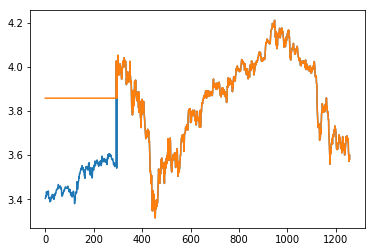

In [21]:
plt.plot(inter.loc["WRK"].values)
plt.plot(piv.loc["WRK"].fillna(np.mean(piv.loc["WRK"])).values)

plt.show()

In [22]:
train_df = df[df["year"] != "2019"]
test_df = df[df["year"] == "2019"]
train_df

,date,open,high,low,close,volume,Name,log_open,log_high_minus_open,log_low_minus_open,log_close,log_volume,year
0,2014-04-25,120.3255,120.7310,119.6115,120.3784,2093074,MMM,4.790201,0.033644,-0.595158,4.790640,14.554144,2014
1,2014-04-28,121.1453,121.9563,119.8583,120.9690,2244309,MMM,4.796991,0.066721,-1.068044,4.795534,14.623908,2014
2,2014-04-29,121.5332,121.5597,120.3784,121.2511,1820903,MMM,4.800187,0.002180,-0.954736,4.797864,14.414843,2014
3,2014-04-30,121.3216,122.7056,121.0572,122.6086,2906766,MMM,4.798445,0.113431,-0.218171,4.808997,14.882552,2014
4,2014-05-01,122.9701,124.7243,122.6351,124.1248,3997985,MMM,4.811941,0.141645,-0.272796,4.821288,15.201301,2014
5,2014-05-02,124.8477,125.0240,123.2962,123.5166,5758462,MMM,4.827095,0.014111,-1.250500,4.816376,15.566181,2014
6,2014-05-05,122.6527,124.3364,122.2208,123.9485,2711091,MMM,4.809357,0.136340,-0.352754,4.819866,14.812862,2014
7,2014-05-06,123.6576,123.7899,122.6792,122.7849,2299671,MMM,4.817516,0.010693,-0.794364,4.810434,14.648277,2014
8,2014-05-07,123.3932,124.5127,122.6836,124.4157,2238499,MMM,4.815376,0.090317,-0.576732,4.823628,14.621316,2014
9,2014-05-08,124.1865,125.2795,123.8604,124.1425,1939407,MMM,4.821784,0.087628,-0.262934,4.821430,14.477893,2014



### Why do you need to do this as opposed to splitting into random segments?

Because this is time series data, if we split into random segments, it'll be out of order

# Part 3: RNN

In [20]:
#train = np.random.random((500, 365*4)) + np.arange(0, 365*4)
#test = np.abs(np.random.random((500, 75)))  + np.arange(365*4, 365*4+75)

# 2: Predict on All data

In [103]:
train, test = inter.iloc[:, :-78].values, inter.iloc[:, -78:].values
train.shape, test.shape

((505, 1180), (505, 78))

In [105]:
step = 50
sc = MinMaxScaler(feature_range = (0, 1))
trans = sc.fit_transform(inter.values)
training_set_scaled, testing_set_scaled, inputs = trans[:, :-78], trans[:, -78:], trans[:, -(78+step):]
real_stock_price = test.copy()
training_set_scaled = training_set_scaled.reshape(505, 1180, 1)
#test = test.reshape(505, 78, 1)
training_set_scaled.shape, testing_set_scaled.shape

((505, 1180, 1), (505, 78))

In [107]:
X_train = []
y_train = []
for j in range(len(train)):
    for i in range(step, len(train[j])-step):
        X_train.append(training_set_scaled[j][i-step:i, 0])
        y_train.append(training_set_scaled[j][i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape, y_train.shape

((545400, 50, 1), (545400,))

In [108]:
regressor = Sequential()

regressor.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train[:100000], y_train[:100000], epochs = 1, batch_size = 256)


Epoch 1/1
100000/100000 [==============================] - 36s 359us/step - loss: 0.0096


In [109]:
inputs = inputs.reshape(505, 128, 1)
inputs.shape

(505, 128, 1)

In [110]:
X_final = []
for j in range(len(inputs)):
    X_test = []
    for i in range(step, len(inputs[0])):
        X_test.append(inputs[j][i-step:i, 0])
    X_test = np.array(X_test)
    X_final.append(X_test)
X_final = np.array(X_final)
X_final.shape

(505, 78, 50)

In [111]:

X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], X_final.shape[2], 1))
predicted_stock_prices = np.zeros((505, 78, 1))
for i in range(505):
    predicted_stock_prices[i, :] = regressor.predict(X_final[i])
predicted_stock_prices.shape

(505, 78, 1)

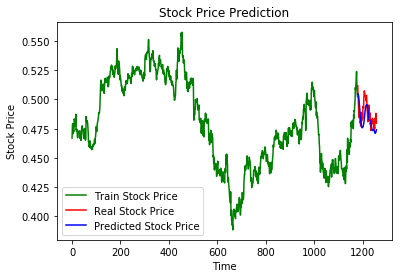

In [112]:
val = 100
# Visualising the results
real_stock_price = testing_set_scaled[val]
l = len(training_set_scaled[0])
plt.plot( np.arange(len(training_set_scaled[0])), training_set_scaled[val], color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(predicted_stock_prices[0])), predicted_stock_prices[val], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Loss change by step size

In [123]:
def make_model(step_size):
    regressor = Sequential()

    regressor.add(LSTM(units = 50, input_shape = (step_size, 1)))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(units = 1))
    

   
    return regressor


In [126]:
losses = []
for step in [1, 50, 150, 300]:
    step = 50
    sc = MinMaxScaler(feature_range = (0, 1))
    trans = sc.fit_transform(inter.values)
    inputs = trans[:, -(78+step):]
    training_set_scaled = training_set_scaled.reshape(505, 1180, 1)
    X_train = []
    y_train = []
    for j in range(len(train)):
        for i in range(step, len(train[j])-step):
            X_train.append(training_set_scaled[j][i-step:i, 0])
            y_train.append(training_set_scaled[j][i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    regressor = make_model(step)
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    regressor.fit(X_train[:10000], y_train[:10000], epochs = 1, batch_size = 256)

    inputs = inputs.reshape(505, 78 + step, 1)
    X_final = []
    for j in range(len(inputs)):
        X_test = []
        for i in range(step, len(inputs[0])):
            X_test.append(inputs[j][i-step:i, 0])
        X_test = np.array(X_test)
        X_final.append(X_test)
    X_final = np.array(X_final)
    X_final = np.reshape(X_final, (X_final.shape[0], X_final.shape[1], X_final.shape[2], 1))
    predicted_stock_prices = np.zeros((505, 78, 1))
    for i in range(505):
        predicted_stock_prices[i, :] = regressor.predict(X_final[i])
    l=np.mean(np.square(predicted_stock_prices.reshape(testing_set_scaled.shape) - testing_set_scaled))
    losses.append(l)


Epoch 1/1
10000/10000 [==============================] - 7s 665us/step - loss: 0.0312
Epoch 1/1
10000/10000 [==============================] - 7s 668us/step - loss: 0.0318
Epoch 1/1
10000/10000 [==============================] - 7s 675us/step - loss: 0.0231
Epoch 1/1
10000/10000 [==============================] - 7s 674us/step - loss: 0.0446


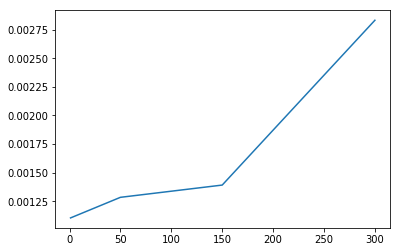

In [127]:
plt.plot([1, 50, 150, 300], losses)

# 3: Predict next day (Single stock model)

In [75]:
def get_model(type='RNN', outputs=1):
    regressor = Sequential()
    if type == 'RNN':
        regressor.add(SimpleRNN(units = 50, input_shape = (X_train.shape[1], 1)))
    elif type == 'GRU':
        regressor.add(GRU(units = 50, input_shape = (X_train.shape[1], 1)))
    else:
        regressor.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(outputs))
    return regressor

In [23]:
MMM_train = train_df[train_df["Name"] == "MMM"]["log_open"].values
MMM_test = test_df[test_df["Name"] == "MMM"]["log_open"].values
real_stock_price = MMM_test
MMM_train = MMM_train.reshape(-1, 1)
MMM_test = MMM_test.reshape(-1, 1)
MMM_train.shape

(1180, 1)

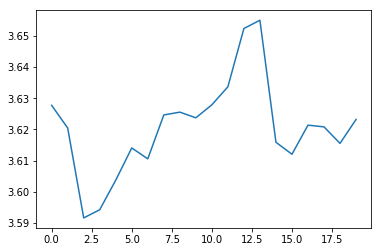

In [24]:
plt.plot(np.arange(0, 365*4)[:20], train[0][0:20])

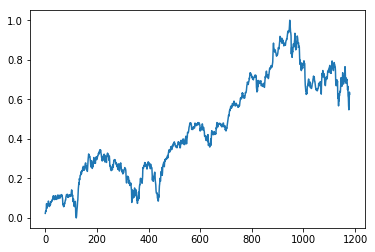

In [25]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(MMM_train)
plt.plot( np.arange(len(training_set_scaled)), training_set_scaled)

In [44]:
X_train = []
y_train = []
step = 50
for i in range(step, len(MMM_train)-step):
    X_train.append(training_set_scaled[i-step:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((1080, 50), (1080,))

In [47]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1080, 50, 1)

In [ ]:
inputs = np.concatenate((MMM_train[-step:], MMM_test[:]))
inputs = sc.transform(inputs)


## RNN

In [37]:
# RNN model
regressor_rnn = get_model('RNN')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [52]:
regressor_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 256)

Epoch 1/5
1080/1080 [==============================] - 1s 522us/step - loss: 0.0191
Epoch 2/5
1080/1080 [==============================] - 0s 150us/step - loss: 0.0139
Epoch 3/5
1080/1080 [==============================] - 0s 146us/step - loss: 0.0132
Epoch 4/5
1080/1080 [==============================] - 0s 151us/step - loss: 0.0098
Epoch 5/5
1080/1080 [==============================] - 0s 136us/step - loss: 0.0081


In [53]:
X_test = []
for i in range(step, len(inputs)):
    X_test.append(inputs[i-step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor_rnn.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

(78, 1)

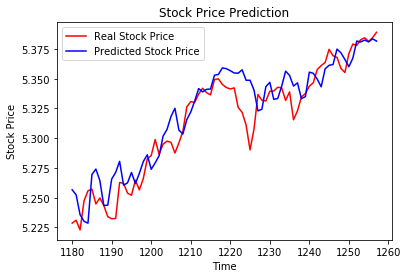

In [54]:
# Visualising the results
l = len(training_set_scaled)
#plt.plot( np.arange(len(training_set_scaled)), MMM_train, color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## GRU

In [59]:
regressor_gru = get_model('GRU')
regressor_gru.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_gru.fit(X_train, y_train, epochs = 5, batch_size = 256)

Epoch 1/5
1080/1080 [==============================] - 1s 1ms/step - loss: 0.1241
Epoch 2/5
1080/1080 [==============================] - 0s 327us/step - loss: 0.0446
Epoch 3/5
1080/1080 [==============================] - 0s 294us/step - loss: 0.0102
Epoch 4/5
1080/1080 [==============================] - 0s 325us/step - loss: 0.0129
Epoch 5/5
1080/1080 [==============================] - 0s 315us/step - loss: 0.0148


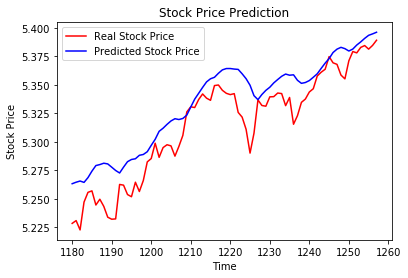

In [60]:
X_test = []
for i in range(step, len(inputs)):
    X_test.append(inputs[i-step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor_gru.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape
# Visualising the results
l = len(training_set_scaled)
#plt.plot( np.arange(len(training_set_scaled)), MMM_train, color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## LSTM

In [66]:
regressor_lstm = get_model('LSTM')
regressor_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_lstm.fit(X_train, y_train, epochs = 15, batch_size = 256)

Epoch 1/15
1080/1080 [==============================] - 2s 2ms/step - loss: 0.3611
Epoch 2/15
1080/1080 [==============================] - 0s 349us/step - loss: 0.2199
Epoch 3/15
1080/1080 [==============================] - 0s 376us/step - loss: 0.0994
Epoch 4/15
1080/1080 [==============================] - 0s 377us/step - loss: 0.0224
Epoch 5/15
1080/1080 [==============================] - 0s 386us/step - loss: 0.0327
Epoch 6/15
1080/1080 [==============================] - 0s 408us/step - loss: 0.0154
Epoch 7/15
1080/1080 [==============================] - 0s 390us/step - loss: 0.0137
Epoch 8/15
1080/1080 [==============================] - 0s 384us/step - loss: 0.0158
Epoch 9/15
1080/1080 [==============================] - 0s 414us/step - loss: 0.0125
Epoch 10/15
1080/1080 [==============================] - 0s 353us/step - loss: 0.0090
Epoch 11/15
1080/1080 [==============================] - 0s 415us/step - loss: 0.0088
Epoch 12/15
1080/1080 [==============================] - 0s 370us

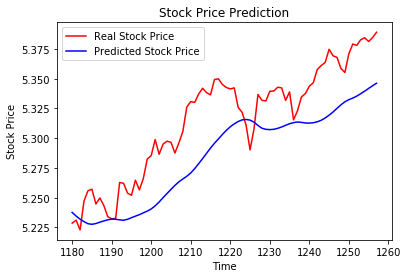

In [67]:
X_test = []
for i in range(step, len(inputs)):
    X_test.append(inputs[i-step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape
# Visualising the results
l = len(training_set_scaled)
#plt.plot( np.arange(len(training_set_scaled)), MMM_train, color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Predict on next week

In [69]:
X_train_week = []
y_train_week = []
step = 50
for i in range(step, len(MMM_train)-step-7):
    X_train_week.append(training_set_scaled[i-step:i, 0])
    y_train_week.append(training_set_scaled[i:i+7, 0])
X_train_week, y_train_week = np.array(X_train_week), np.array(y_train_week)
X_train_week.shape, y_train_week.shape

((1073, 50), (1073, 7))

In [70]:
X_train_week = np.reshape(X_train_week, (X_train_week.shape[0], X_train_week.shape[1], 1))
X_train_week.shape

(1073, 50, 1)

In [71]:
inputs_week = np.concatenate((MMM_train[-step:], MMM_test[:]))
inputs_week = sc.transform(inputs_week)


## RNN

In [83]:
regressor_rnn_week = get_model('RNN', 7)
regressor_rnn_week.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_rnn_week.fit(X_train_week, y_train_week, epochs = 15, batch_size = 256)

Epoch 1/15
1073/1073 [==============================] - 1s 1ms/step - loss: 0.1995
Epoch 2/15
1073/1073 [==============================] - 0s 147us/step - loss: 0.0929
Epoch 3/15
1073/1073 [==============================] - 0s 131us/step - loss: 0.0514
Epoch 4/15
1073/1073 [==============================] - 0s 156us/step - loss: 0.0358
Epoch 5/15
1073/1073 [==============================] - 0s 144us/step - loss: 0.0302
Epoch 6/15
1073/1073 [==============================] - 0s 153us/step - loss: 0.0266
Epoch 7/15
1073/1073 [==============================] - 0s 145us/step - loss: 0.0233
Epoch 8/15
1073/1073 [==============================] - 0s 147us/step - loss: 0.0202
Epoch 9/15
1073/1073 [==============================] - 0s 154us/step - loss: 0.0196
Epoch 10/15
1073/1073 [==============================] - 0s 147us/step - loss: 0.0174
Epoch 11/15
1073/1073 [==============================] - 0s 144us/step - loss: 0.0171
Epoch 12/15
1073/1073 [==============================] - 0s 143us

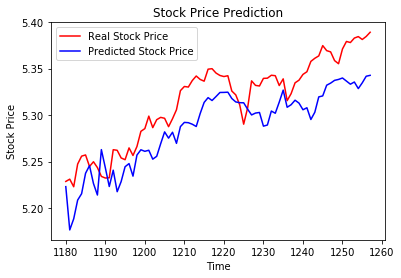

In [84]:
X_test = []
for i in range(step, len(inputs)):
    X_test.append(inputs[i-step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor_rnn_week.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price[:,0]
# Visualising the results
l = len(training_set_scaled)
#plt.plot( np.arange(len(training_set_scaled)), MMM_train, color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## GRU

In [85]:
regressor_gru_week = get_model('RNN', 7)
regressor_gru_week.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_gru_week.fit(X_train_week, y_train_week, epochs = 30, batch_size = 256)

Epoch 1/30
1073/1073 [==============================] - 1s 1ms/step - loss: 0.3794
Epoch 2/30
1073/1073 [==============================] - 0s 148us/step - loss: 0.1864
Epoch 3/30
1073/1073 [==============================] - 0s 149us/step - loss: 0.1056
Epoch 4/30
1073/1073 [==============================] - 0s 137us/step - loss: 0.0671
Epoch 5/30
1073/1073 [==============================] - 0s 142us/step - loss: 0.0460
Epoch 6/30
1073/1073 [==============================] - 0s 155us/step - loss: 0.0337
Epoch 7/30
1073/1073 [==============================] - 0s 157us/step - loss: 0.0276
Epoch 8/30
1073/1073 [==============================] - 0s 156us/step - loss: 0.0243
Epoch 9/30
1073/1073 [==============================] - 0s 145us/step - loss: 0.0207
Epoch 10/30
1073/1073 [==============================] - 0s 145us/step - loss: 0.0191
Epoch 11/30
1073/1073 [==============================] - 0s 147us/step - loss: 0.0171
Epoch 12/30
1073/1073 [==============================] - 0s 151us

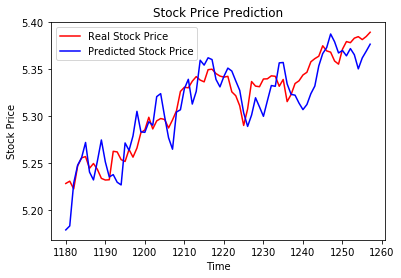

In [86]:
X_test = []
for i in range(step, len(inputs)):
    X_test.append(inputs[i-step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor_gru_week.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price[:,0]
# Visualising the results
l = len(training_set_scaled)
#plt.plot( np.arange(len(training_set_scaled)), MMM_train, color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## LSTM

In [89]:
regressor_lstm_week = get_model('RNN', 7)
regressor_lstm_week.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor_lstm_week.fit(X_train_week, y_train_week, epochs = 30, batch_size = 256)

Epoch 1/30
1073/1073 [==============================] - 1s 1ms/step - loss: 0.1994
Epoch 2/30
1073/1073 [==============================] - 0s 139us/step - loss: 0.1108
Epoch 3/30
1073/1073 [==============================] - 0s 138us/step - loss: 0.0723
Epoch 4/30
1073/1073 [==============================] - 0s 148us/step - loss: 0.0496
Epoch 5/30
1073/1073 [==============================] - 0s 142us/step - loss: 0.0383
Epoch 6/30
1073/1073 [==============================] - 0s 138us/step - loss: 0.0288
Epoch 7/30
1073/1073 [==============================] - 0s 137us/step - loss: 0.0232
Epoch 8/30
1073/1073 [==============================] - 0s 159us/step - loss: 0.0216
Epoch 9/30
1073/1073 [==============================] - 0s 160us/step - loss: 0.0197
Epoch 10/30
1073/1073 [==============================] - 0s 151us/step - loss: 0.0177
Epoch 11/30
1073/1073 [==============================] - 0s 162us/step - loss: 0.0165
Epoch 12/30
1073/1073 [==============================] - 0s 146us

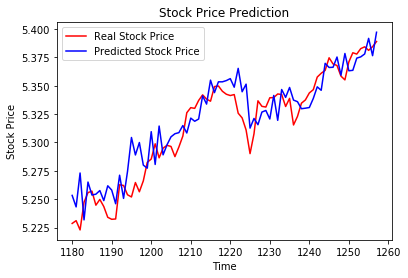

In [90]:
X_test = []
for i in range(step, len(inputs)):
    X_test.append(inputs[i-step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor_lstm_week.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = predicted_stock_price[:,0]
# Visualising the results
l = len(training_set_scaled)
#plt.plot( np.arange(len(training_set_scaled)), MMM_train, color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Added feature (day of week)

# Deeper network (LSTM)

In [93]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 3, batch_size = 32)


Epoch 1/3
1080/1080 [==============================] - 15s 14ms/step - loss: 0.0551
Epoch 2/3
1080/1080 [==============================] - 11s 10ms/step - loss: 0.0062
Epoch 3/3
1080/1080 [==============================] - 11s 11ms/step - loss: 0.0052


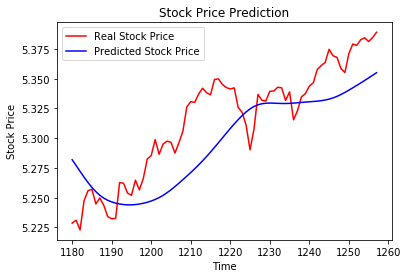

In [94]:
X_test = []
for i in range(step, len(inputs)):
    X_test.append(inputs[i-step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape
# Visualising the results
l = len(training_set_scaled)
#plt.plot( np.arange(len(training_set_scaled)), MMM_train, color = 'green', label = 'Train Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(np.arange(l, l+len(real_stock_price)), predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()